___

<center><h1>Modelado Predictivo - Youtube</h1></center>

___

<center><h2>Pragma</h2></center><br>
<center> Assessment Consultor Cientifico de Datos </center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presentado por:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>

<center>Mayo 2025</center>
<p></p>

In [18]:

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# XGBoost
import xgboost as xgb

# Model persistence
import joblib

In [2]:
df = pd.read_csv('../data/cleaned_youtube_data.csv')

## Feature importance Model

In [3]:
# Create target variable (top 10% of views)
view_threshold = df['views'].quantile(0.9)
df['is_top_10_percent'] = (df['views'] >= view_threshold).astype(int)

In [4]:
features = [
    'weighted_engagement_score',
    'like_ratio',
    'days_until_trending',
    'is_morning',
    'is_afternoon',
    'is_evening',
    'is_night'
]

In [5]:
# Prepare X and y
X = df[features]
y = df['is_top_10_percent']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

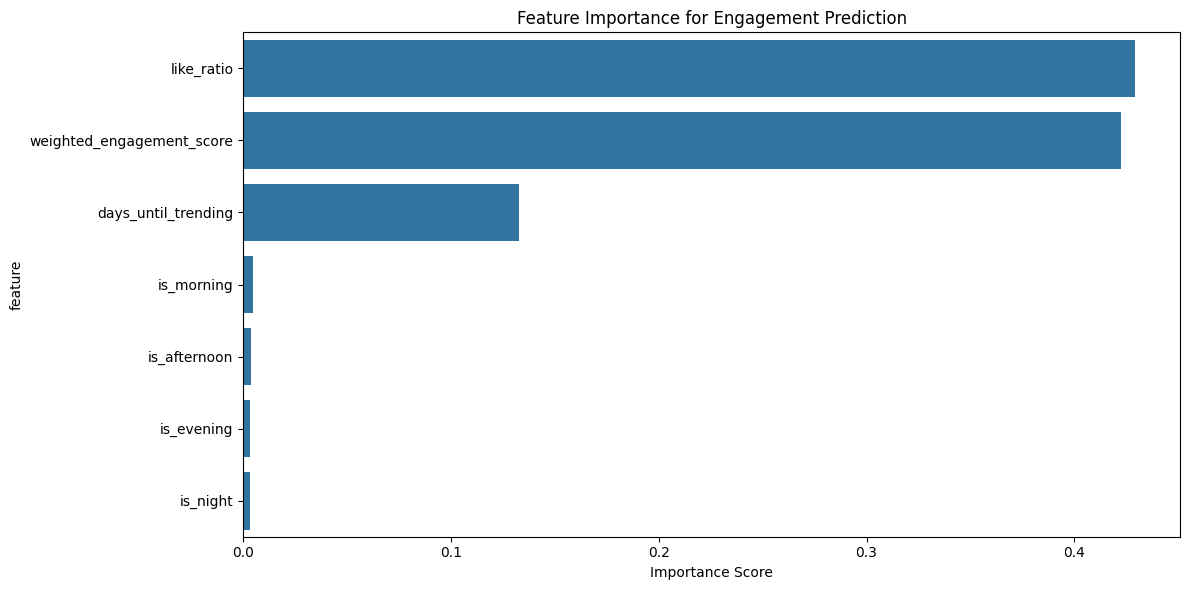

In [10]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Engagement Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [11]:
# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)


Feature Importance Scores:
                     feature  importance
1                 like_ratio    0.429407
0  weighted_engagement_score    0.422657
2        days_until_trending    0.132822
3                 is_morning    0.004747
4               is_afternoon    0.003977
5                 is_evening    0.003291
6                   is_night    0.003099


## Views Forecasting

In [13]:
# Define features and target
features = [
    'weighted_engagement_score',
    'like_ratio',
    'days_until_trending',
    'is_morning',
    'is_afternoon',
    'is_evening',
    'is_night',
    'category_name',
    'publish_day'
]
target = 'views'

In [14]:
# Split the data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Create preprocessing pipeline
numeric_features = ['weighted_engagement_score', 'like_ratio', 'days_until_trending', 'is_morning', 'is_afternoon', 'is_evening', 'is_night']
categorical_features = ['category_name', 'publish_day']

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [19]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1]
        }
    }
}

In [20]:
results = {}
best_models = {}

for name, model_info in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    # Perform GridSearchCV with 5-fold cross-validation
    if model_info['params']:
        grid_search = GridSearchCV(
            pipeline,
            model_info['params'],
            cv=5,
            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
            refit='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        
        cv_results = {
            'MAE': -grid_search.cv_results_['mean_test_neg_mean_absolute_error'],
            'RMSE': -grid_search.cv_results_['mean_test_neg_root_mean_squared_error'],
            'R2': grid_search.cv_results_['mean_test_r2']
        }
        
        best_params = grid_search.best_params_
    else:

        cv_results = {
            'MAE': -cross_val_score(pipeline, X_train, y_train, 
                                  cv=5, scoring='neg_mean_absolute_error'),
            'RMSE': -cross_val_score(pipeline, X_train, y_train, 
                                   cv=5, scoring='neg_root_mean_squared_error'),
            'R2': cross_val_score(pipeline, X_train, y_train, 
                                cv=5, scoring='r2')
        }
        pipeline.fit(X_train, y_train)
        best_models[name] = pipeline
        best_params = {}
    
    results[name] = {
        'CV_MAE_mean': np.mean(cv_results['MAE']),
        'CV_MAE_std': np.std(cv_results['MAE']),
        'CV_RMSE_mean': np.mean(cv_results['RMSE']),
        'CV_RMSE_std': np.std(cv_results['RMSE']),
        'CV_R2_mean': np.mean(cv_results['R2']),
        'CV_R2_std': np.std(cv_results['R2']),
        'Best_Params': best_params
    }
    
    y_pred = best_models[name].predict(X_test)
    results[name].update({
        'Test_MAE': mean_absolute_error(y_test, y_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Test_R2': r2_score(y_test, y_pred)
    })

/Users/jorgeforero/JFCL Projects/PRG_test/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [21]:
# Results Summary
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                      CV_MAE_mean     CV_MAE_std    CV_RMSE_mean  \
Linear Regression  2644092.550922   33080.577961  7230551.129181   
Random Forest       1548596.75186  222154.582741   4350283.15508   
XGBoost            2137198.870833  266053.539173  5645898.641667   

                     CV_RMSE_std CV_R2_mean CV_R2_std  \
Linear Regression  524216.596456   0.066658  0.003214   
Random Forest      297900.454892   0.652017  0.047589   
XGBoost            830883.610694   0.412472  0.162235   

                                                         Best_Params  \
Linear Regression                                                 {}   
Random Forest      {'model__max_depth': None, 'model__min_samples...   
XGBoost            {'model__learning_rate': 0.1, 'model__max_dept...   

                         Test_MAE       Test_RMSE   Test_R2  
Linear Regression  2633908.142281  6700420.366672  0.067611  
Random Forest      1219888.996311  3618231.768731  0.7281

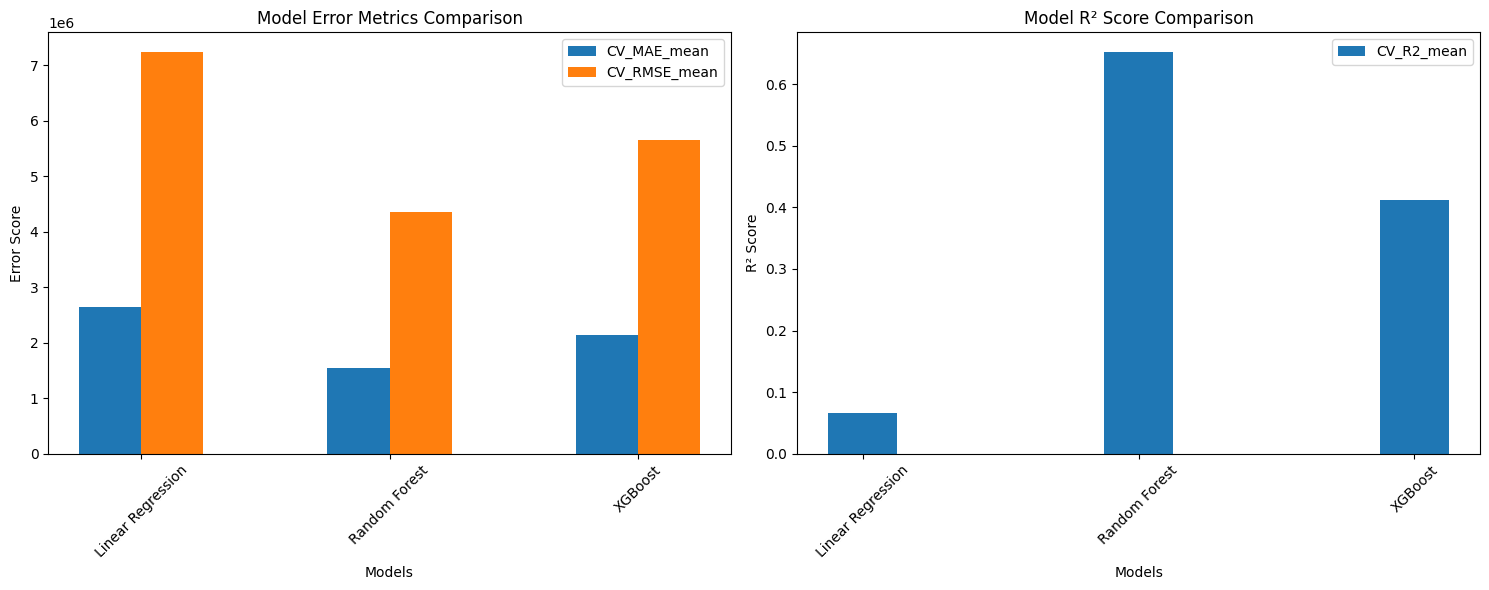

In [ ]:
# Results Charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

metrics_error = ['CV_MAE_mean', 'CV_RMSE_mean']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics_error):
    ax1.bar(x + i*width, [results[model][metric] for model in models.keys()], 
            width, label=metric)

ax1.set_xlabel('Models')
ax1.set_ylabel('Error Score')
ax1.set_title('Model Error Metrics Comparison')
ax1.set_xticks(x + width/2)
ax1.set_xticklabels(models.keys(), rotation=45)
ax1.legend()

ax2.bar(x, [results[model]['CV_R2_mean'] for model in models.keys()], 
        width, label='CV_R2_mean')
ax2.set_xlabel('Models')
ax2.set_ylabel('R² Score')
ax2.set_title('Model R² Score Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models.keys(), rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()